#Install and import dependencies

In [ ]:
# eda_and_features.py
import glob
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import mean_squared_error

pd.options.mode.chained_assignment = None

#Clean data

In [ ]:
########## 1. Load dữ liệu (Parquet) ##########
def load_parquet_all(path_pattern):
    files = sorted(glob.glob(path_pattern))
    if not files:
        print("No parquet files:", path_pattern)
        return pd.DataFrame()
    dfs = [pd.read_parquet(f) for f in files]
    df = pd.concat(dfs, ignore_index=True)
    return df

df = load_parquet_all("/bronze_py/*.parquet")   # hoặc "data/bronze/*.parquet"
print("Loaded rows:", len(df))
if df.empty:
    raise SystemExit("No data loaded. Run producer/consumer first.")

Loaded rows: 127525


In [ ]:
df = df[~df.index.duplicated(keep='first')]

In [ ]:
print(df)

       sensor  speed   timestamp
0       roadA     34  1762594904
1       roadB     19  1762594906
2       roadC     42  1762594908
3       roadA     55  1762594910
4       roadB     12  1762594912
...       ...    ...         ...
127520  roadC     54  1762799194
127521  roadA     16  1762799196
127522  roadC     33  1762799198
127523  roadC     40  1762799200
127524  roadB     33  1762799202

[127525 rows x 3 columns]


In [ ]:
def ensure_datetime(df, ts_col='timestamp'):
    """Convert unix timestamp (seconds or ms) to pandas datetime in-place copy."""
    df = df.copy()
    max_ts = df[ts_col].max()
    unit = 'ms' if max_ts > 10**12 else 's'
    df['dt'] = pd.to_datetime(df[ts_col], unit=unit)
    return df

# ---------- PART 1: basic aggregation ----------
def aggregate(
    df,
    sensor_col='sensor',
    ts_col='timestamp',
    speed_col='speed',
    freq='5min',
    include_empty=False
):
    df = ensure_datetime(df, ts_col)
    # named aggregation
    agg = (
        df
        .groupby([sensor_col, pd.Grouper(key='dt', freq=freq)])[speed_col]
        .agg(
            count='count',
            median='median',
            mean='mean',
            std='std',
            min='min',
            max='max',
            q25=lambda x: np.nanpercentile(x, 25) if len(x)>0 else np.nan,
            q75=lambda x: np.nanpercentile(x, 75) if len(x)>0 else np.nan,
        )
    ).reset_index().rename(columns={'dt':'interval_start'})
    minutes = pd.Timedelta(freq).total_seconds() / 60.0
    agg['count_per_min'] = agg['count'] / minutes
    agg['is_empty'] = agg['count'] == 0

    if include_empty:
        sensors = df[sensor_col].unique()
        start = df['dt'].min().floor(freq)
        end = df['dt'].max().ceil(freq)
        full_time = pd.date_range(start=start, end=end, freq=freq)
        full_index = pd.MultiIndex.from_product([sensors, full_time], names=[sensor_col, 'interval_start'])
        agg = agg.set_index([sensor_col, 'interval_start']).reindex(full_index).reset_index()
        agg['count'] = agg['count'].fillna(0).astype(int)
        agg['count_per_min'] = agg['count'] / minutes
        agg['is_empty'] = agg['count'] == 0
        # keep other statistic columns NaN where no data (so you can detect missing)
    return agg.sort_values([sensor_col, 'interval_start']).reset_index(drop=True)

In [ ]:
agg_df = aggregate(df, include_empty=True, freq='5min')

In [ ]:
print(agg_df)

     sensor      interval_start  count  median       mean        std   min  \
0     roadA 2025-11-08 09:40:00     76    35.5  35.000000  12.644894  10.0   
1     roadA 2025-11-08 09:45:00    104    41.0  38.365385  15.328796  11.0   
2     roadA 2025-11-08 09:50:00     88    28.0  30.636364  14.228175  10.0   
3     roadA 2025-11-08 09:55:00     94    33.0  33.446809  13.652852  11.0   
4     roadA 2025-11-08 10:00:00    112    30.5  31.767857  14.893001  10.0   
...     ...                 ...    ...     ...        ...        ...   ...   
2044  roadC 2025-11-10 18:10:00     58    33.5  34.310345  13.641020  12.0   
2045  roadC 2025-11-10 18:15:00     56    36.5  36.125000  14.362910  11.0   
2046  roadC 2025-11-10 18:20:00     53    34.0  34.603774  15.407715  10.0   
2047  roadC 2025-11-10 18:25:00     18    34.5  34.055556  16.075089  10.0   
2048  roadC 2025-11-10 18:30:00      0     NaN        NaN        NaN   NaN   

       max    q25    q75  count_per_min  is_empty  
0     58.0 

#Feature Engineering

In [ ]:
def feature_engineer(agg_df, sensor_col='sensor', time_col='interval_start',
                           window=3, flow_thresh_per_min=5.0, encode_sensor='onehot'):

    a = agg_df.copy()
    # ensure datetime
    if not np.issubdtype(a[time_col].dtype, np.datetime64):
        a[time_col] = pd.to_datetime(a[time_col])
    # sort for rolling
    a = a.sort_values([sensor_col, time_col]).reset_index(drop=True)
    grp = a.groupby(sensor_col, sort=False)

    # Rolling features for 'count' and 'median'
    for col in ['count', 'median']:
        if col in a.columns:
            a[f'roll{window}_mean_{col}'] = grp[col].transform(lambda s: s.rolling(window=window, min_periods=1).mean())
            a[f'roll{window}_median_{col}'] = grp[col].transform(lambda s: s.rolling(window=window, min_periods=1).median())
        else:
            a[f'roll{window}_mean_{col}'] = np.nan
            a[f'roll{window}_median_{col}'] = np.nan

    # Time-based numeric/binary features
    a['hour'] = a[time_col].dt.hour
    a['minute'] = a[time_col].dt.minute
    a['weekday'] = a[time_col].dt.weekday  # Monday=0
    a['is_weekend'] = a['weekday'].isin([5,6]).astype(int)
    # define night as 22:00-5:59
    a['is_night'] = ((a['hour'] >= 22) | (a['hour'] <= 5)).astype(int)

    # Cyclical encodings for hour and minute
    a['hour_sin'] = np.sin(2 * np.pi * a['hour'] / 24)
    a['hour_cos'] = np.cos(2 * np.pi * a['hour'] / 24)
    a['min_sin'] = np.sin(2 * np.pi * a['minute'] / 60)
    a['min_cos'] = np.cos(2 * np.pi * a['minute'] / 60)

    # Binary low_flow label
    if 'count_per_min' in a.columns:
        a['low_flow'] = (a['count_per_min'] < flow_thresh_per_min).astype(int)
    else:
        a['low_flow'] = np.nan

    a["is_empty"] = a["is_empty"].astype(int)

    # Sensor encoding
    if encode_sensor == 'onehot':
        dummies = pd.get_dummies(a[sensor_col], prefix=sensor_col)
        dummies = dummies.astype(int)

        a = pd.concat([a.reset_index(drop=True), dummies.reset_index(drop=True)], axis=1)
    elif encode_sensor == 'label':
        from sklearn.preprocessing import LabelEncoder
        le = LabelEncoder()
        a[f'{sensor_col}_label'] = le.fit_transform(a[sensor_col].astype(str))
    else:
        raise ValueError("encode_sensor must be 'onehot' or 'label'")

    return a

In [ ]:
new_featured_df = feature_engineer(agg_df)

In [ ]:
print(new_featured_df)
new_featured_df.to_csv("/content/sample_data/new_features_df")

     sensor      interval_start  count  median       mean        std   min  \
0     roadA 2025-11-08 09:40:00     76    35.5  35.000000  12.644894  10.0   
1     roadA 2025-11-08 09:45:00    104    41.0  38.365385  15.328796  11.0   
2     roadA 2025-11-08 09:50:00     88    28.0  30.636364  14.228175  10.0   
3     roadA 2025-11-08 09:55:00     94    33.0  33.446809  13.652852  11.0   
4     roadA 2025-11-08 10:00:00    112    30.5  31.767857  14.893001  10.0   
...     ...                 ...    ...     ...        ...        ...   ...   
2044  roadC 2025-11-10 18:10:00     58    33.5  34.310345  13.641020  12.0   
2045  roadC 2025-11-10 18:15:00     56    36.5  36.125000  14.362910  11.0   
2046  roadC 2025-11-10 18:20:00     53    34.0  34.603774  15.407715  10.0   
2047  roadC 2025-11-10 18:25:00     18    34.5  34.055556  16.075089  10.0   
2048  roadC 2025-11-10 18:30:00      0     NaN        NaN        NaN   NaN   

       max    q25    q75  ...  is_weekend  is_night  hour_sin  

In [ ]:
def plot_rolling_timeseries(
    agg_df,
    sensor_col='sensor',
    time_col='interval_start',
    value_col='median',         # speed column to plot
    resample_rule='5T',         # e.g. '1min', '5min', '30min'
    resample_agg='median',      # 'median' or 'mean'
    rolling_window=3,           # rolling mean window (points)
    interpolate=True,
    sensors=None,               # list of sensors to plot (None -> all)
    figsize=(12,5),
    title=None,
    savepath=None
):
    """
    Plot per-sensor time series: resample -> interpolate -> rolling(window).mean()
    """
    df = agg_df.copy()
    # ensure datetime
    if not np.issubdtype(df[time_col].dtype, np.datetime64):
        df[time_col] = pd.to_datetime(df[time_col])
    # choose sensors
    if sensors is None:
        sensors = df[sensor_col].unique()
    plt.figure(figsize=figsize)
    for s in sensors:
        sub = df[df[sensor_col] == s].sort_values(time_col)
        if sub.shape[0] == 0:
            continue
        series = sub.set_index(time_col)[value_col]
        # resample
        if resample_agg == 'median':
            series = series.resample(resample_rule).median()
        elif resample_agg == 'mean':
            series = series.resample(resample_rule).mean()
        else:
            raise ValueError("resample_agg must be 'median' or 'mean'")
        # interpolate missing because resample introduces NaNs
        if interpolate:
            series = series.interpolate(method='time', limit_direction='both')
        # rolling mean
        rolling = series.rolling(window=rolling_window, min_periods=1).mean()
        plt.plot(rolling.index, rolling.values, label=str(s))
    plt.legend()
    if title is None:
        title = f"{resample_rule} resampled + {rolling_window}-period rolling {value_col}"
    plt.title(title)
    plt.xlabel("time")
    plt.ylabel(f"{value_col} (rolling mean)")
    plt.grid(True)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath, dpi=300)
    plt.show()


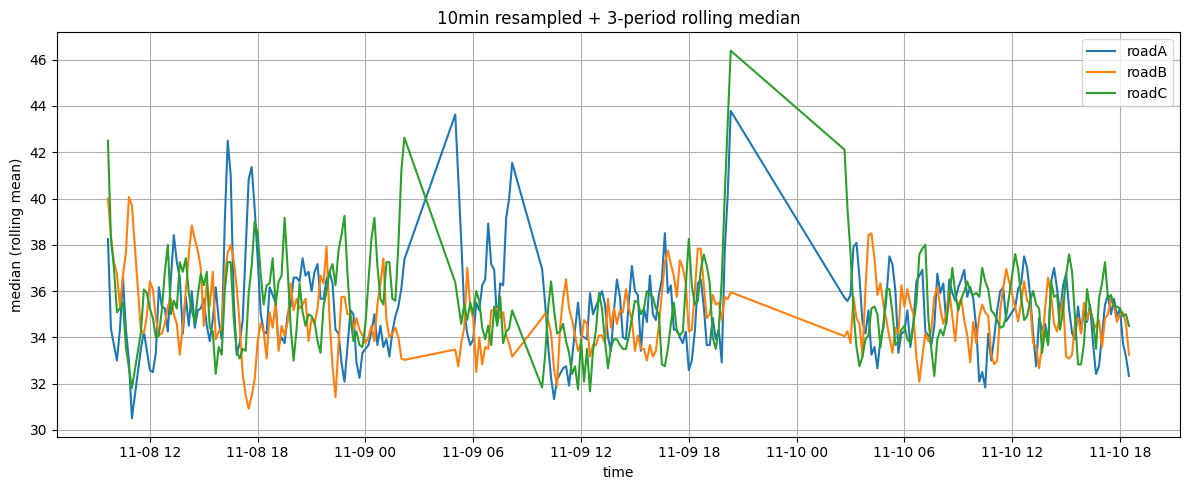

In [ ]:
plot_rolling_timeseries(new_featured_df,
                       resample_rule='10min',
                       resample_agg='median',
                       rolling_window=3)


In [ ]:
def append_congestion(
    ag_df,
    sensor_col='sensor',
    time_col='interval_start',
    value_col='median',
    window=3,
    thr_low=34,   # rolling < thr_low -> level 2
    thr_mid=38    # thr_low <= rolling < thr_mid -> level 1; else 0
):

    df = ag_df.copy()
    if not pd.api.types.is_datetime64_any_dtype(df[time_col]):
        df[time_col] = pd.to_datetime(df[time_col])
    df = df.sort_values([sensor_col, time_col]).reset_index(drop=True)

    # compute rolling mean per sensor (fast & simple)
    df['_rolling'] = df.groupby(sensor_col)[value_col].transform(
        lambda s: s.rolling(window=window, min_periods=1).mean()
    )

    # init congestion_level as NA where rolling is NA, else 0
    df['congestion_level'] = 1
    mask_notna = df['_rolling'].notna()
    df.loc[mask_notna, 'congestion_level'] = 0

    # apply thresholds
    df.loc[mask_notna & (df['_rolling'] < thr_low), 'congestion_level'] = 2
    df.loc[mask_notna & (df['_rolling'] >= thr_low) & (df['_rolling'] < thr_mid), 'congestion_level'] = 1

    # optional: if you want rows flagged empty (is_empty==True) to be NA (keep missing)
    if 'is_empty' in df.columns:
        df.loc[df['is_empty'] == True, 'congestion_level'] = pd.NA

    # convert to nullable Int type
    df['congestion_level'] = df['congestion_level'].astype('Int64')

    # drop helper col and return
    df = df.drop(columns=['_rolling'])
    return df

In [ ]:
classified_df = append_congestion(new_featured_df)

In [ ]:
print(classified_df)
classified_df.to_csv("/content/sample_data/classified_df")

     sensor      interval_start  count  median       mean        std   min  \
0     roadA 2025-11-08 09:40:00     76    35.5  35.000000  12.644894  10.0   
1     roadA 2025-11-08 09:45:00    104    41.0  38.365385  15.328796  11.0   
2     roadA 2025-11-08 09:50:00     88    28.0  30.636364  14.228175  10.0   
3     roadA 2025-11-08 09:55:00     94    33.0  33.446809  13.652852  11.0   
4     roadA 2025-11-08 10:00:00    112    30.5  31.767857  14.893001  10.0   
...     ...                 ...    ...     ...        ...        ...   ...   
2044  roadC 2025-11-10 18:10:00     58    33.5  34.310345  13.641020  12.0   
2045  roadC 2025-11-10 18:15:00     56    36.5  36.125000  14.362910  11.0   
2046  roadC 2025-11-10 18:20:00     53    34.0  34.603774  15.407715  10.0   
2047  roadC 2025-11-10 18:25:00     18    34.5  34.055556  16.075089  10.0   
2048  roadC 2025-11-10 18:30:00      0     NaN        NaN        NaN   NaN   

       max    q25    q75  ...  is_night  hour_sin      hour_cos

In [ ]:
processed_df = classified_df.drop(columns=['sensor', 'interval_start'])
clean_df = processed_df[processed_df['is_empty'] != 1].reset_index(drop=True)

In [ ]:
print(clean_df)

      count  median       mean        std   min   max    q25    q75  \
0        76    35.5  35.000000  12.644894  10.0  58.0  24.00  46.00   
1       104    41.0  38.365385  15.328796  11.0  60.0  25.75  50.50   
2        88    28.0  30.636364  14.228175  10.0  60.0  18.00  40.25   
3        94    33.0  33.446809  13.652852  11.0  60.0  23.25  45.00   
4       112    30.5  31.767857  14.893001  10.0  60.0  18.00  43.25   
...     ...     ...        ...        ...   ...   ...    ...    ...   
1539     41    34.0  33.707317  14.632573  11.0  60.0  21.00  44.00   
1540     58    33.5  34.310345  13.641020  12.0  60.0  24.25  46.50   
1541     56    36.5  36.125000  14.362910  11.0  60.0  23.75  48.00   
1542     53    34.0  34.603774  15.407715  10.0  58.0  21.00  51.00   
1543     18    34.5  34.055556  16.075089  10.0  55.0  18.00  50.25   

      count_per_min  is_empty  ...  is_night  hour_sin      hour_cos  \
0              15.2         0  ...         0  0.707107 -7.071068e-01   
1  

#Preparing training data and validation data

In [ ]:
from sklearn.model_selection import train_test_split

X = clean_df.drop(columns=['congestion_level'])
y = clean_df['congestion_level']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


Train shape: (1235, 27) (1235,)
Test shape: (309, 27) (309,)


#XGBoost

In [ ]:
import xgboost as xgb

In [ ]:

xgb_params = {
    'eta': 0.0175,
    'max_depth': 9,
    'subsample': 0.80,
    'min_child_weight': 5,
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'lambda': 0.8,
    'alpha': 0.4,
    'base_score': np.mean(X_test),
    'device': 'cuda:0',
    'tree_method': 'hist',
    'num_parallel_tree': 3
}

num_boost_rounds = 841
model = xgb.train(
    dict(xgb_params, silent=1),
    dtrain,
    num_boost_round=num_boost_rounds,
)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:45:21] WARNING: /workspace/src/context.cc:53: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:45:21] WARNING: /workspace/src/context.cc:207: Device is changed from GPU to CPU as we couldn't find any available GPU on the system.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:45:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


#Evaluation

In [ ]:
# Evaluation utilities for XGBoost regression model predicting ordinal labels (0,1,2)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, balanced_accuracy_score,
    precision_recall_fscore_support, confusion_matrix, classification_report
)
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.multiclass import unique_labels
from scipy.stats import spearmanr
from sklearn.metrics import cohen_kappa_score



In [ ]:
def _to_class(preds, classes=None):
    cls = np.rint(preds).astype('int')
    if classes is not None:
        mn, mx = min(classes), max(classes)
        cls = np.clip(cls, mn, mx)
    else:
        # enforce non-negative
        cls = np.clip(cls, 0, np.max(cls))
    return cls

In [ ]:
def evaluate_xgb(
    model,
    X,
    y_true,
    dataset_name='test',
    as_regression=True,
    classes=(0,1,2),
    plot_cm=True,
    return_preds=False
):
    try:
        # model.predict accepts DMatrix or raw arrays
        preds_cont = model.predict(X)
    except Exception as e:
        # fallback: if X is DataFrame/ndarray it's fine; else try X.values
        preds_cont = model.predict(getattr(X, "values", X))
    preds_cont = np.array(preds_cont).reshape(-1)

    # Regression metrics (on continuous preds vs true labels as numeric)
    mae = mean_absolute_error(y_true, preds_cont)
    mse = mean_squared_error(y_true, preds_cont)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, preds_cont)

    # Convert to discrete classes
    preds_cls = _to_class(preds_cont, classes=classes)

    # If y_true may not be ints, convert
    y_true_arr = np.array(y_true).astype('int')

    # Classification metrics
    acc = accuracy_score(y_true_arr, preds_cls)
    bal_acc = balanced_accuracy_score(y_true_arr, preds_cls)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true_arr, preds_cls, average='macro', zero_division=0
    )
    precision_weight, recall_weight, f1_weight, _ = precision_recall_fscore_support(
        y_true_arr, preds_cls, average='weighted', zero_division=0
    )
    prf_per_class = precision_recall_fscore_support(y_true_arr, preds_cls, average=None, zero_division=0)

    # Confusion matrix
    labels_sorted = np.array(sorted(list(classes)))
    cm = confusion_matrix(y_true_arr, preds_cls, labels=labels_sorted)

    # Cohen's kappa and Quadratic Weighted Kappa (weights='quadratic')
    kappa = cohen_kappa_score(y_true_arr, preds_cls, weights=None)           # linear/unweighted
    qwk = cohen_kappa_score(y_true_arr, preds_cls, weights='quadratic')     # quadratic weighted kappa

    # Spearman rank correlation between true and continuous preds
    try:
        rho, rho_p = spearmanr(y_true_arr, preds_cont)
    except Exception:
        rho, rho_p = (np.nan, np.nan)

    # Classification report text
    cls_report = classification_report(y_true_arr, preds_cls, labels=labels_sorted, zero_division=0)

    # Build results dict
    results = {
        'dataset': dataset_name,
        # regression
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'r2': r2,
        # classification
        'accuracy': acc,
        'balanced_accuracy': bal_acc,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_weighted': precision_weight,
        'recall_weighted': recall_weight,
        'f1_weighted': f1_weight,
        'cohen_kappa': kappa,
        'qwk': qwk,
        'spearman_rho': rho,
        'spearman_p': rho_p,
        'confusion_matrix': cm,
        'labels': labels_sorted,
        'classification_report': cls_report
    }

    # Print summary
    print(f"=== Evaluation on {dataset_name} ===")
    print(f"Regression (continuous preds): MAE={mae:.4f}, RMSE={rmse:.4f}, R2={r2:.4f}")
    print(f"Classification (after rounding): Acc={acc:.4f}, BalancedAcc={bal_acc:.4f}, F1_macro={f1_macro:.4f}, QWK={qwk:.4f}")
    print()
    print("Classification report:\n", cls_report)
    print("Confusion matrix (rows=true, cols=pred) with labels:", labels_sorted)
    print(cm)
    print()

    # Plot confusion matrix
    if plot_cm:
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=labels_sorted, yticklabels=labels_sorted)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title(f"Confusion matrix ({dataset_name})")
        plt.show()

    if return_preds:
        return results, preds_cont, preds_cls
    return results


=== Evaluation on Test set ===
Regression (continuous preds): MAE=0.0004, RMSE=0.0012, R2=1.0000
Classification (after rounding): Acc=1.0000, BalancedAcc=1.0000, F1_macro=1.0000, QWK=1.0000

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       1.00      1.00      1.00       172
           2       1.00      1.00      1.00       114

    accuracy                           1.00       309
   macro avg       1.00      1.00      1.00       309
weighted avg       1.00      1.00      1.00       309

Confusion matrix (rows=true, cols=pred) with labels: [0 1 2]
[[ 23   0   0]
 [  0 172   0]
 [  0   0 114]]



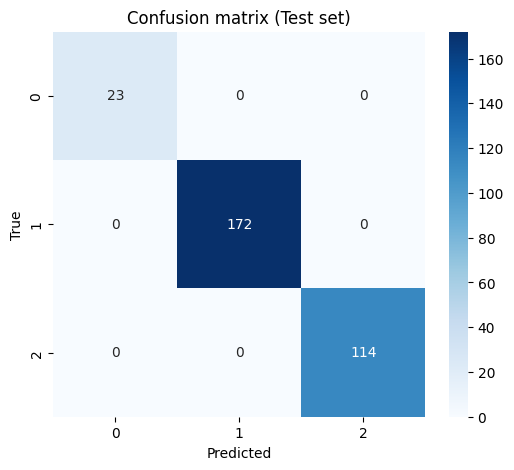

In [ ]:
results = evaluate_xgb(model, dtest, y_test, dataset_name='Test set')